In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [3]:
rfm_data=pd.read_csv(r"/home/gokul/Downloads/rfm.csv")
rfm_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
'''wanted columns
rfm1=rfm_data.drop(['Country','StockCode','Description'],axis=1)
rfm1.head()'''

"wanted columns\nrfm1=rfm_data.drop(['Country','StockCode','Description'],axis=1)\nrfm1.head()"

In [6]:
#to find total price
rfm_data['TotalPrice'] = rfm_data['Quantity'] * rfm_data['UnitPrice']
rfm_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [7]:
rfm_data.InvoiceDate.min()

'1/10/2011 10:04'

In [8]:
rfm_data.InvoiceDate.max()

'9/9/2011 9:52'

In [9]:
#NOW = dt.datetime(2011,9,9)
rfm_data['InvoiceDate'] = pd.to_datetime(rfm_data['InvoiceDate'])

In [10]:
#find recency,frequency and monitery
rfmTable = rfm_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (rfm_data.InvoiceDate.max() - x.max()).days,
                                           'InvoiceNo': lambda x: len(x),'TotalPrice': lambda x: x.sum()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'TotalPrice': 'monetary_value'}, inplace=True)

rfmTable.head()


,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


In [11]:
quantiles = rfmTable.quantile(q=[0.20,0.40,0.60,0.80])
quantiles = quantiles.to_dict()
quantiles 

{'recency': {0.2: 10.0, 0.4: 31.0, 0.6: 70.0, 0.8: 177.80000000000018},
 'frequency': {0.2: 14.0, 0.4: 29.0, 0.6: 58.0, 0.8: 124.0},
 'monetary_value': {0.2: 234.39200000000002,
  0.4: 465.4119999999999,
  0.6: 909.134,
  0.8: 2002.0920000000003}}

In [12]:
def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 4
    else:
        return 5
    
def FMScore(x,p,d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 2
    else:
        return 1
rfmTable['r_quartile'] =rfmTable['recency'].apply(RScore, args=('recency',quantiles,))
rfmTable['f_quartile'] =rfmTable['frequency'].apply(FMScore, args=('frequency',quantiles,))
rfmTable['m_quartile'] =rfmTable['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
rfmTable.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,2,0.00,5,5,5
12347.0,1,182,4310.00,1,1,1
12348.0,74,31,1797.24,4,3,2
12349.0,18,73,1757.55,2,2,2
12350.0,309,17,334.40,5,4,4


In [13]:
rfmTable['fm_quartile'] = (rfmTable['f_quartile'] + rfmTable['m_quartile'])/2

In [14]:
rfmseg=rfmTable.drop(['f_quartile','m_quartile'],axis=1)
rfmseg.reset_index(inplace=True)
rfmseg[['fm_quartile','CustomerID']]=rfmseg[['fm_quartile','CustomerID']].astype(int)
rfmseg.head()

,CustomerID,recency,frequency,monetary_value,r_quartile,fm_quartile
0,12346,325,2,0.00,5,5
1,12347,1,182,4310.00,1,1
2,12348,74,31,1797.24,4,2
3,12349,18,73,1757.55,2,2
4,12350,309,17,334.40,5,4


In [15]:
def rseg(a):
    if (a['r_quartile']>3) and (a['fm_quartile']>3):
        return 'champion'
    elif (a['r_quartile']>1) and (a['fm_quartile']>2):
        return 'loyal customer'
    elif (a['r_quartile']>2) and (a['fm_quartile']<4):
        return 'potential loyalist'
    elif (a['r_quartile']>3) and (a['fm_quartile']<2):
        return 'recent customer'
    elif (a['r_quartile'] in (3,4)) and (a['fm_quartile']<2):
          return 'promising'
    elif (a['r_quartile'] in (2,3)) and (a['fm_quartile']<3):
        return 'customer need attention'
    elif (a['r_quartile'] in (2,3)) and (a['fm_quartile']<2):
            return 'about to sleep'
    elif (a['r_quartile']<3) and (a['fm_quartile']>=2):
            return 'at risk'
    elif (a['r_quartile']<2) and (a['fm_quartile']>3):
            return "can't lose them"
    elif (a['r_quartile']<3) and (a['fm_quartile']<3):
            return 'hibernating'
    elif (a['r_quartile']<3) and (a['fm_quartile']<3):
            return 'lost'
    
    

In [16]:
rfmseg['segment']=rfmseg[['r_quartile','fm_quartile']].apply(rseg,axis=1)
rfmseg.head()

,CustomerID,recency,frequency,monetary_value,r_quartile,fm_quartile,segment
0,12346,325,2,0.00,5,5,champion
1,12347,1,182,4310.00,1,1,hibernating
2,12348,74,31,1797.24,4,2,potential loyalist
3,12349,18,73,1757.55,2,2,customer need attention
4,12350,309,17,334.40,5,4,champion


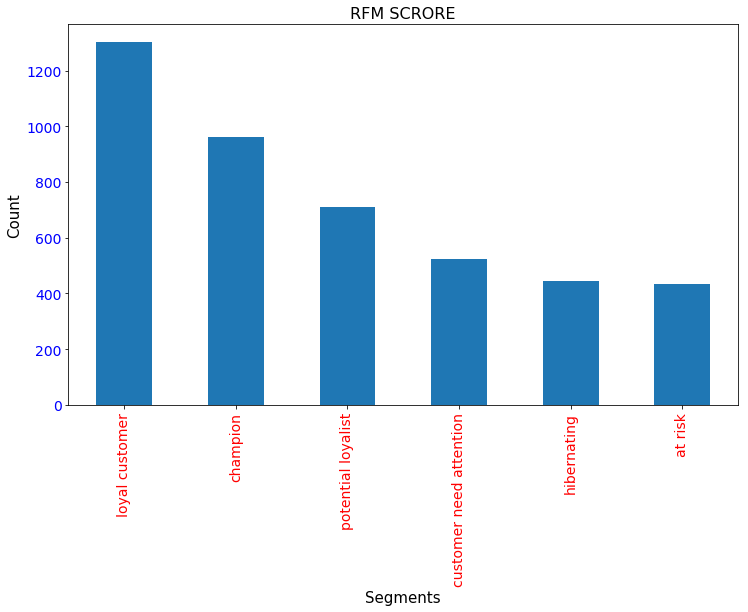

In [17]:
rfm_finish=rfmseg['segment'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12,7))
rfm_finish.plot(kind='bar')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Segments',fontsize=15)
plt.title('RFM SCRORE',fontsize=16)
plt.xticks(fontsize=14,color='red')
plt.yticks(fontsize=14,color='blue')
plt.show()

In [18]:
rfmseg.segment.value_counts()

loyal customer             1301
champion                    962
potential loyalist          711
customer need attention     522
hibernating                 444
at risk                     432
Name: segment, dtype: int64

In [19]:
#using R_QUARTILE and FM_QUARTILE
hmap=rfmseg.pivot_table(index='CustomerID',values=['r_quartile','fm_quartile'],columns='segment',aggfunc=len,fill_value=0)
hmap

fm_quartile                                               \
segment        at risk champion customer need attention hibernating   
CustomerID                                                            
12346                0        1                       0           0   
12347                0        0                       0           1   
12348                0        0                       0           0   
12349                0        0                       1           0   
12350                0        1                       0           0   
12352                0        0                       0           0   
12353                0        1                       0           0   
12354                0        0                       0           0   
12355                0        1                       0           0   
12356                0        0                       1           0   
12357                0        0                       0           0   
12358                1        0                       0           0   
12359                0        0                       0           1   
12360                0        0                       0           0   
12361                0        1                       0           0   
12362                0        0                       0           1   
12363                0        0                       0           0   
12364                1        0                       0           0   
12365                0        1                       0           0   
12367                1        0                       0           0   
12370                0        0                       0           0   
12371                0        0                       0           0   
12372                0        0                       0           0   
12373                0        1                       0           0   
12374                0        0                       0           0   
12375                1        0                       0           0   
12377                0        0                       0           0   
12378                0        0                       0           0   
12379                0        0                       0           0   
12380                0        0                       1           0   
...                ...      ...                     ...         ...   
18245                0        0                       0           1   
18246                0        0                       0           0   
18248                0        0                       0           0   
18249                0        0                       0           0   
18250                0        1                       0           0   
18251                0        0                       0           0   
18252                0        0                       0           0   
18255                0        1                       0           0   
18256                0        1                       0           0   
18257                0        0                       0           0   
18259                0        0                       1           0   
18260                0        0                       0           0   
18261                0        0                       0           0   
18262                0        1                       0           0   
18263                0        0                       1           0   
18265                0        0                       0           0   
18268                0        1                       0           0   
18269                0        1                       0           0   
18270                0        0                       0           0   
18272                0        0                       0           1   
18273                1        0                       0           0   
18274                0        0                       0           0   
18276                0        0    

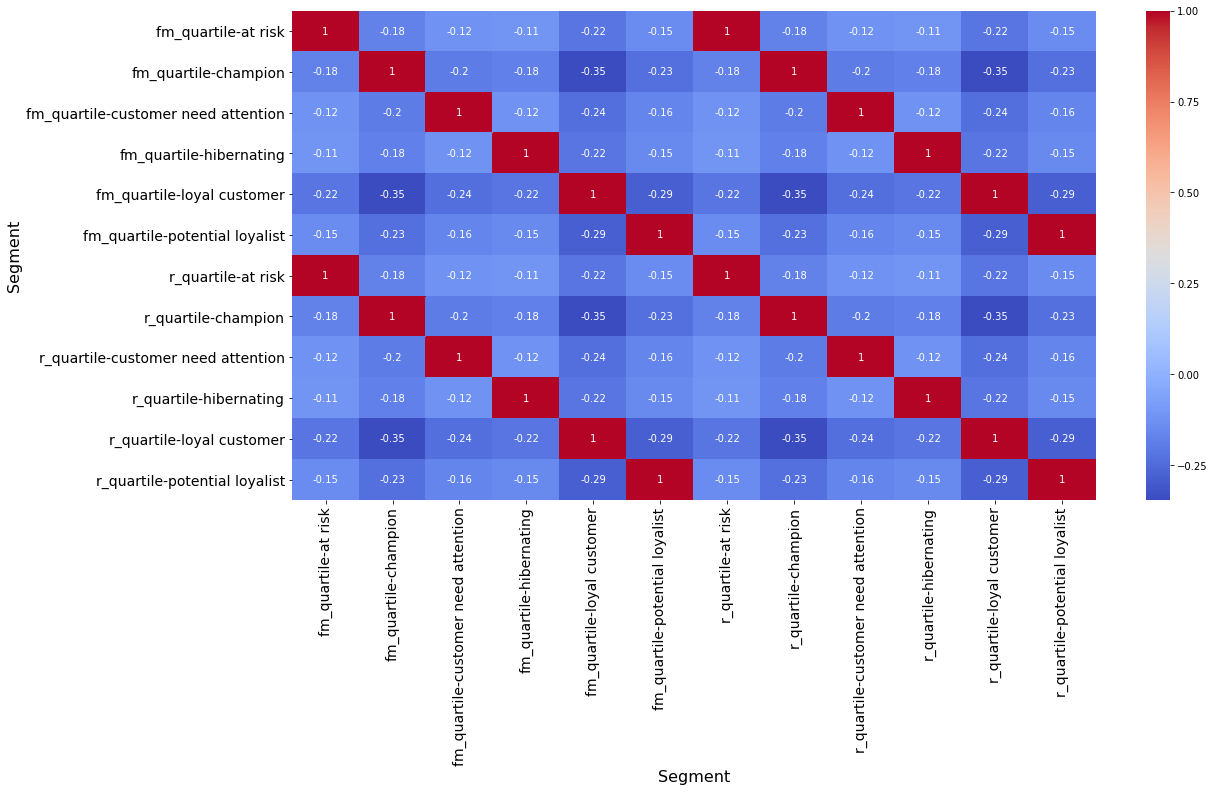

In [45]:
plt.figure(figsize=(18,9))
sns.heatmap(hmap.corr(),annot=True,cmap='coolwarm')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Segment',fontsize=16)
plt.ylabel('Segment',fontsize=16)
plt.savefig('plot')

In [32]:
heat_map=rfmseg.pivot_table(index='r_quartile',values='fm_quartile',columns='segment',aggfunc=len)

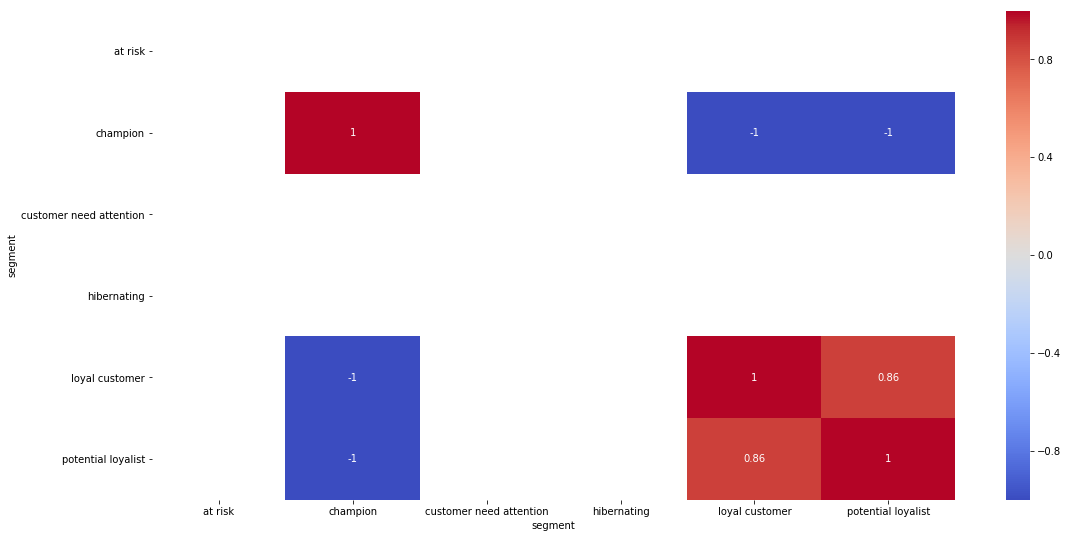

In [42]:
plt.figure(figsize=(18,9))
sns.heatmap(heat_map.corr(),annot=True,cmap='coolwarm')
plt.savefig('img')